### Full Multi Grid Solution of the Dilaton Field Equation in Three Dimensions for Calculating the Shape of the Flux-tubes
##### Vikram Vyas

#### About this notebook
This notebook was used to do the numerical calculations described in the section 4.1 of the accompanying paper "Flux-tubes and their intrinsic shape in confining gauge theories with gravitational dual" Please feel free to use it for any accademic purpose. For any comments or clarification send me an email: vikram@physicsinfield.org

#### How to use this notebook

The notebook requires two python files:

utility_3DimMG.py

AiStringSource.py

        
#### References
For multigrid algorithm used see:

J. Stewart. Python for Scientists. Cambridge University Press, 2017.

and the python implementation

https://github.com/AbhilashReddyM/GeometricMultigrid

#### Acknowledgments
I would like to thank the world wide community of python developers.


#### Python preliminaries

In [1]:
import numpy as np

# for plotting
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# for using Cython
%load_ext Cython

#### Utility functions for Multigrid

In [2]:
from utility_3DimMG import L2_norm, prolong_lin, restric, restrict_hw

In [3]:
%%cython
cimport numpy as np
cimport cython
@cython.boundscheck(False) # turn of bounds-checking for entire function
@cython.wraparound(False)
@cython.cdivision(True)

cdef A(float a, float nz):
    return (1.0/( a * nz))**3


cdef B(float sigma, float a, float nz):
    return sigma**2 * ((1.0 /(a * nz))**3 - a * nz)


cdef C(float sigma, float a, float nz):
    return 4*A(a, nz+0.5)+B(sigma, a, nz-0.5)+B(sigma, a, nz+0.5)


# solving L(error) = errorCentre - errorB - errorZ = source
def updateError(float sigma, int Nz, int Nx1, int Nx2,  
                np.ndarray[np.float_t, ndim = 3, negative_indices = False,  mode = 'c'] phi,  
                np.ndarray[np.float_t, ndim = 3, negative_indices = False,  mode = 'c'] source):
    
        cdef int nz, nx1, nx2
        cdef float a, D, deltaPhiB, deltaPhiZ, newPhi
        
        # lattice constant in the units of z_0
        a = 1.0/(Nz-1)
        
        for nz in range(1, Nz - 1):
            for nx1 in range(1, Nx1 - 1):
                for nx2 in range(1, Nx2 - 1):
                    if nz == Nz-2:
                        phi[Nz - 1, nx1, nx2] = phi[Nz - 2, nx1, nx2] # Neumann B.C. at z = Nz
                    deltaPhiB = A(a, nz + 0.5) * (phi[nz, nx1+1, nx2]+phi[nz, nx1-1, nx2]+phi[nz, nx1, nx2+1]+phi[nz, nx1, nx2-1])
                    deltaPhiZ = B(sigma, a, nz + 0.5) * phi[nz+1, nx1, nx2] + B(sigma, a, nz-0.5)*phi[nz-1, nx1, nx2]
                    newPhi = (1.0/C(sigma, a, nz)) * (deltaPhiB + deltaPhiZ + source[nz, nx1, nx2])
                    phi[nz, nx1, nx2] = newPhi

def relaxError(float sigma, int Nz, int Nx1, int Nx2,  
               np.ndarray[np.float_t, ndim = 3, negative_indices = False,  mode = 'c'] phi,  
               np.ndarray[np.float_t, ndim = 3, negative_indices = False,  mode = 'c'] source, int nit = 1):
    cdef int ii
    for ii in range(nit):
        updateError(sigma, Nz, Nx1, Nx2, phi, source)
    return phi

def residue(float sigma, int Nz, int Nx1, int Nx2, 
            np.ndarray[np.float_t, ndim = 3, negative_indices = False,  mode = 'c'] phi,
            np.ndarray[np.float_t, ndim = 3, negative_indices = False,  mode = 'c'] jSource, 
            np.ndarray[np.float_t, ndim = 3, negative_indices = False,  mode = 'c'] residue):
    
    # L(phi) = phiCentre - phiB - phiZ = jSource
    # res = jSource - L(phi)
 
    # lattice constant in the units of z_0 = 1
    a = 1.0/(Nz - 1.0)
    
    #residue = np.zeros((Nz, Nx1, Nx2), float)
    for nz in range(1, Nz - 1):
        for nx1 in range(1, Nx1 - 1):
            for nx2 in range(1, Nx2 - 1):
                if nz == Nz-2:
                        phi[Nz - 1, nx1, nx2] = phi[Nz - 2, nx1, nx2] # Neumann B.C. at z = Nz
                phiCentre = C(sigma, a, nz) * phi[nz, nx1, nx2]
                phiB = A(a, nz + 0.5) * (phi[nz, nx1+1, nx2]+phi[nz, nx1-1, nx2]+phi[nz, nx1, nx2+1]+phi[nz, nx1, nx2-1])
                phiZ = B(sigma, a, nz + 0.5) * phi[nz+1, nx1, nx2] + B(sigma, a, nz-0.5)*phi[nz-1, nx1, nx2]
                residue[nz, nx1, nx2] = jSource[nz, nx1, nx2] + (phiB + phiZ - phiCentre)
    return residue

In [4]:
def V_cycle(sigma, nz, nx1, nx2, num_levels, phi, source, level=1):
    
    # solve exactly at the bottom layer - recursion ends here
    if (level==num_levels):
        phi = relaxError(sigma, nz, nx1, nx2, phi, source, nit=100)
        return phi
    
    #Step 1: Relax L(phi) = source on this grid and calculate the residue
    phi = relaxError(sigma, nz, nx1, nx2, phi, source, nit=75)
    res = np.zeros_like(phi)
    res = residue(sigma, nz, nx1, nx2, phi, source, res)
    
    
    #Step 2: Restrict residual to coarse grid
    res_c = restrict_hw(res)
    
    #Step 3:Solve Le_c=res_c on the coarse grids recursively
    coarseGridShape = np.shape(res_c)
    NzC, Nx1C, Nx2C = coarseGridShape[0], coarseGridShape[1], coarseGridShape[2]
    err_c = np.zeros_like(res_c)
    err_c = V_cycle(sigma, NzC, Nx1C, Nx2C, num_levels, err_c, res_c, level+1)
    
    
    #Step 4: Interpolate(prolong) e_c to fine grid and add to phi
    phi = phi + prolong_lin(err_c)
    
    #Step 5: Relax L(phi) = source on this grid 
    phi = relaxError(sigma, nz, nx1, nx2, phi, source, nit=75)
    
    return phi

In [5]:
def FMG(sigma, nz, nx1, nx2, num_levels, source, nv=1, level=1):
    # solve exactly at the bottom layer 
    
    if (level==num_levels):
        phi = np.zeros_like(source)
        phi = relaxError(sigma, nz, nx1, nx2, phi, source, nit=100)
        print("solved the bottom grid")
        return phi
    
    #Step 1: Restrict the rhs to a coarse grid
    source_c = restrict_hw(source)
    
    #Step 2: Solve the coarse grid problem using FMG
    coarseGridShape = np.shape(source_c)
    NzC, Nx1C, Nx2C = coarseGridShape[0], coarseGridShape[1], coarseGridShape[2]
    current_level = level + 1
    phi_c = FMG(sigma, NzC, Nx1C, Nx2C, num_levels, source_c, nv, current_level)
    
    #Step 3: Interpolate phi_c to the fine grid
    phi = prolong_lin(phi_c)
    
    
    #step 4: Execute 'nv' V-cycles
    for _ in range(nv):
        phi = V_cycle(sigma, nz, nx1, nx2, num_levels-level, phi, source)
    print("finished V-cycles for level = ", num_levels-level)
    return phi

### Geometry of the fine lattice
Length along the radial direction in the units of lattice constants $a$. Lattice constant along $X_1$ and $X_2$ is $b =\sigma a$

In [6]:
num_levels = 6
Lz = Lx1 = Lx2 = Nz = 2**(num_levels + 1)
a = 1.0/Lz
sigma = 5.0
b = a * sigma
print("L = ", Lz, "a = ", a ,"b = sigma * b = ",  b)

L =  128 a =  0.0078125 b = sigma * b =  0.0390625


For each direction, the number of points is one more than the length

In [7]:
Nz = Lz + 1
Nx1 = Lx1 + 1
Nx2 = Lx2 + 1
print(Lz, Nz)

128 129


### Dilaton field
Initially set to zero. This also implements the homogenous Dirichlet on all boundaries
 we will implement Neumann BC on $z = L_z$ plane in the relaxation algorithm.

In [8]:
Phi = np.zeros((Nz,Nx1,Nx2), float)                                    

### Source function for an open string

In [9]:
from AiStringSource import StringSource

$$g = \frac{\lambda^1/2}{8\pi}$$
Is the coupling constant of the dilaton field with the open string.

$N_{zM}$ is the $z$ coordinate of the top of the string.

In [10]:
g = -10 # negative sign is to incorporate L(phi) = - stringSource
NzM =  127 #Nz - int(Nz/5.0)
#print("NzM = ", NzM, " LzM = ", NzM * a)

In [11]:
myStringSource = StringSource(g, sigma, NzM, Nz, Nx1, Nx2)

In [12]:
stringShape, sourceArray, NxR, NxL = myStringSource.stringShape()

### Distance between the quark and the anti-quark in the units of $z_0$

In [13]:
coordL = NxR - NxL
print(NxR, NxL)
qqbarDistance = coordL * a * sigma # distance between the quark and the antiquark in units of z_0
print("Distance between the quark and the antiquark  = ", qqbarDistance)

94.0 34.0
Distance between the quark and the antiquark  =  2.34375


### Solving using FMG

In [14]:
%%time
Phi = FMG(sigma, Nz, Nx1, Nx2, num_levels, sourceArray, nv = 20, level = 1 )

solved the bottom grid
finished V-cycles for level =  1
finished V-cycles for level =  2
finished V-cycles for level =  3
finished V-cycles for level =  4
finished V-cycles for level =  5
CPU times: user 27min 19s, sys: 6.55 s, total: 27min 25s
Wall time: 26min 39s


In [15]:
res = np.zeros_like(Phi)
res = residue(sigma, Nz, Nx1, Nx2, Phi, sourceArray, res)
resL2Norm = L2_norm(res, a)
print("Final residue = ", round(resL2Norm, 3))

Final residue =  0.041


In [16]:
colorinterpolation = 50
colourMap = plt.cm.jet 
X1, Z = np.meshgrid(np.arange(0, Nz), np.arange(0, Nx1))

In [17]:
nx2C = int(Nx2/2)
dilatonInStringPlane = Phi[:, :, nx2C]

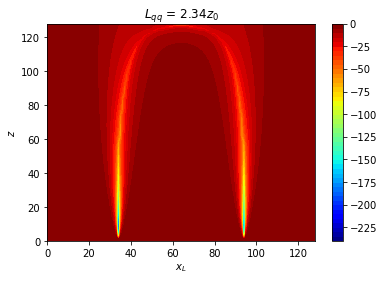

<Figure size 432x288 with 0 Axes>

In [18]:
plt.contourf(Z, X1, dilatonInStringPlane.T, colorinterpolation, cmap=colourMap)
plt.colorbar()
label = "$L_{qq}$ = %4.2f$z_0$" % (qqbarDistance)
plt.title(label)
plt.xlabel("$x_L$")
plt.ylabel("$z$")
# remove the tick marks
#ax3 = plt.axes()
#plt.setp(ax3.get_xticklabels(), visible=False)
#plt.setp(ax3.get_yticklabels(), visible=False)
#ax3.tick_params(axis='both', which='both', length=0)
figCaption = "Dilaton_Field" + str(qqbarDistance)+".png"
plt.savefig(figCaption)
plt.show()
plt.clf()

### Calculating $z_0^4<\Omega|{\widehat{\mathcal{O}}_{F^{2}}}\left(x_1, x_2 \right)|\Omega>_{q\bar{q}}$

In [19]:
def B(a, nz):
    return (1.0 /(a * nz))**3 - a * nz
Ez = - (B(a, 0.5)/a) * Phi[1, :, :]

### Ploting the thickness in the central plane

Half Width in the central plane in the units of $z_0$ =  0.58


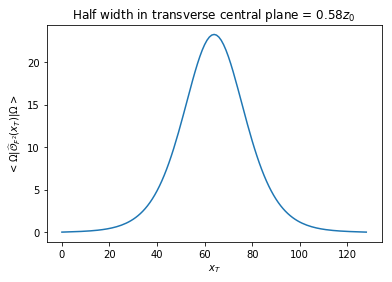

23.3


In [20]:
nx1c = int(Nx1/2)
EzT =  - (B(a, 0.5)/a) * Phi[1, nx1c, :]
xTrange = np.arange(Nx2)
#
# rescale to delinate
EzCutoff = 23.3
EzT[EzT > EzCutoff] = EzCutoff
#
centre = np.sum(xTrange * EzT)/np.sum(EzT)
widthCoord = np.sqrt(np.abs(np.sum((xTrange-centre)**2*EzT)/np.sum(EzT)))
#print("Width in the central plane = ", widthCoord)
physicalWidth = round(widthCoord * sigma * a, 2)
print("Half Width in the central plane in the units of $z_0$ = ", physicalWidth)
#
label = "Half width in transverse central plane = %4.2f$z_0$" % (physicalWidth)
plt.title(label)
plt.xlabel("$x_T$")
plt.ylabel("$<\Omega|{\widehat{\mathcal{O}}_{F^{2}}(x_T)}|\Omega>$")
plt.plot(xTrange, EzT)
figCaption = "Half width in Central Plane" + str(qqbarDistance)+".png"
plt.savefig(figCaption)
plt.show()
EzTmax = np.max(EzT)
print(round(np.max(EzT), 1))

#### Width in the plane containing the quark

Half Width in the quark plane in the units of $z_0$ =  0.69


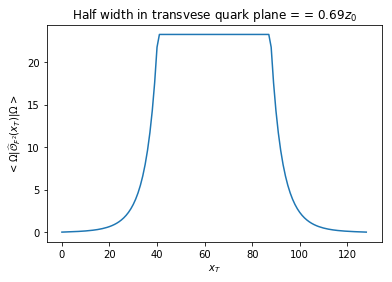

In [21]:
# Flux in the transverse plane containg the quark
EzQ =  - (B(a, 0.5)/a) * Phi[1, int(NxL), :]
# rescale to delinate
EzCutoff = 23.3
EzQ[EzQ > EzCutoff] = EzCutoff
# Width of cutoff distribution
#
centre = np.sum(xTrange * EzQ)/np.sum(EzQ)
widthCoord = np.sqrt(np.abs(np.sum((xTrange-centre)**2*EzQ)/np.sum(EzQ)))

physicalWidthInQuarkPlane = round(widthCoord * sigma * a, 2)
print("Half Width in the quark plane in the units of $z_0$ = ", physicalWidthInQuarkPlane)
#
# Labels
label = "Half width in transvese quark plane = = %4.2f$z_0$" % (physicalWidthInQuarkPlane)

plt.title(label)
plt.xlabel("$x_T$")
plt.ylabel("$<\Omega|{\widehat{\mathcal{O}}_{F^{2}}(x_T)}|\Omega>$")
# Caption
figCaption = "Half width in the Quark Plane" + str(qqbarDistance)+".png"

#
plt.plot(xTrange, EzQ)
plt.savefig(figCaption)
plt.show()

### Plotting the flux-tube

In [22]:
X1, X2 = np.meshgrid(np.arange(0, Nx1), np.arange(0, Nx2))

In [23]:
EzR = Ez

In [24]:
EzCutoff = 23.3 # 1.0 * EzTmax
EzR[EzR > EzCutoff] = EzCutoff

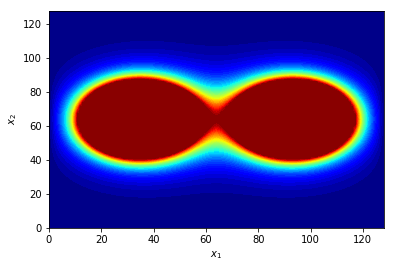

<Figure size 432x288 with 0 Axes>

In [25]:
plt.contourf(X1, X2, EzR.T, colorinterpolation, cmap=colourMap)

# Set Colorbar
#plt.colorbar()

# Show the result in the plot window
figLegend = "Fluxtube " + "Lqqbar = " + str(qqbarDistance) + "Lz = " + str(Lz) + "simga = " + str(sigma) + ".png"
#label = "Normalized flux distribution. $L_{qq}$ = %4.2f$z_0$" % (qqbarDistance)
# Create Figure and Axes instances
label = "Distance between the quark and the antiquark  %4.2f$z_0$" % (qqbarDistance)
#plt.title(label)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
#ax.set_yticklabels([])
#ax.set_xticklabels([])
plt.savefig(figLegend)
plt.show()
plt.clf()

In [29]:
z, x, y = stringShape.nonzero()
%matplotlib auto
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z, zdir='z', c= 'red')
#ax.plot(x. y, z, zdir='z', c = 'red')
cset = ax.contourf(X1, X2, EzR.T, zdir='z', offset = 0, origin = 'image', cmap=colourMap)
ax.set_xlim(0,Nx1)
ax.set_ylim(0, Nx2)
plt.axis('off')

plt.xlabel("$x_L$")
plt.ylabel("$x_T$")

ax.grid(False)

# remove the tick marks
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.tick_params(axis='both', which='both', length=0)
fig.colorbar(cset, shrink = 0.5, aspect = 5)

#Caption
label = "$L = $   %4.2f$z_0$" % (qqbarDistance)
#plt.title(label)

figLegend = "LzM = " + str((NzM +1) * a) + "Lz = " + str(Lz) + "simga = " + str(sigma)
print(figLegend)
plt.show()
figTitle =  "openString "+ "Lqqbar = " + str(qqbarDistance) + "simga = " + str(sigma) + ".png"
plt.savefig(figTitle)

Using matplotlib backend: MacOSX
LzM = 1.0Lz = 128simga = 5.0
